## Main Task
Building a Game Recommendation System with Steam Platform Data!

### Data Understanding
The dataset contains over 41 million cleaned and preprocessed user recommendations (reviews) from a Steam Store - a leading online platform for purchasing and downloading video games, DLC, and other gaming-related content.  
Additionally, it contains detailed information about games and add-ons.  

The dataset consists of three main entities:

1. **games.csv** - a table of games (or add-ons) information on ratings, pricing in US dollars $, release date, etc. A piece of extra non-tabular details on games, such as descriptions and tags, is in a metadata file;
2. **users.csv** - a table of user profiles' public information: the number of purchased products and reviews published;
3. **recommendations.csv** - a table of user reviews: whether the user recommends a product. The table represents a many-many relation between a game entity and a user entity.

The dataset does not contain any personal information about users on a Steam Platform. A preprocessing pipeline anonymized all user IDs. All collected data is accessible to a member of the general public.

Link to the dataset: [https://www.kaggle.com/datasets/antonkozyriev/game-recommendations-on-steam/data]

In [93]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
games_df = pd.read_csv('datasets/games.csv')
users_df = pd.read_csv('datasets/users.csv')
recommendations_df = pd.read_csv('datasets/recommendations.csv')

In [4]:
games_df.head(2)

,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck
0,13500,Prince of Persia: Warrior Within™,2008-11-21,True,False,False,Very Positive,84,2199,9.99,9.99,0.0,True
1,22364,BRINK: Agents of Change,2011-08-03,True,False,False,Positive,85,21,2.99,2.99,0.0,True


In [5]:
games_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50872 entries, 0 to 50871
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   app_id          50872 non-null  int64  
 1   title           50872 non-null  object 
 2   date_release    50872 non-null  object 
 3   win             50872 non-null  bool   
 4   mac             50872 non-null  bool   
 5   linux           50872 non-null  bool   
 6   rating          50872 non-null  object 
 7   positive_ratio  50872 non-null  int64  
 8   user_reviews    50872 non-null  int64  
 9   price_final     50872 non-null  float64
 10  price_original  50872 non-null  float64
 11  discount        50872 non-null  float64
 12  steam_deck      50872 non-null  bool   
dtypes: bool(4), float64(3), int64(3), object(3)
memory usage: 3.7+ MB


In [6]:
users_df.head(2)

,user_id,products,reviews
0,7360263,359,0
1,14020781,156,1


In [7]:
users_df['reviews'].head()

0    0
1    1
2    4
3    4
4    2
Name: reviews, dtype: int64

In [8]:
recommendations_df.head(2)

,app_id,helpful,funny,date,is_recommended,hours,user_id,review_id
0,975370,0,0,2022-12-12,True,36.3,51580,0
1,304390,4,0,2017-02-17,False,11.5,2586,1


In [9]:
recommendations_df['funny'].nunique()

2756

In [10]:
games_df.isnull().sum()

app_id            0
title             0
date_release      0
win               0
mac               0
linux             0
rating            0
positive_ratio    0
user_reviews      0
price_final       0
price_original    0
discount          0
steam_deck        0
dtype: int64

In [11]:
users_df.isnull().sum()

user_id     0
products    0
reviews     0
dtype: int64

In [12]:
recommendations_df.isnull().sum()

app_id            0
helpful           0
funny             0
date              0
is_recommended    0
hours             0
user_id           0
review_id         0
dtype: int64

### EDA on Games Dataset
#### What is the distribution of game ratings?

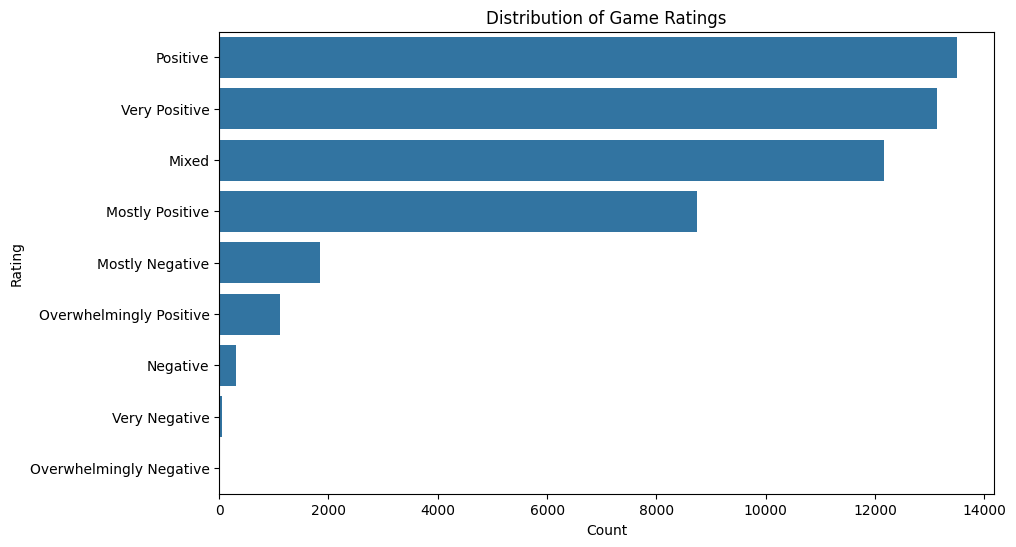

In [13]:
# Count plot for game ratings
plt.figure(figsize=(10, 6))
sns.countplot(y=games_df['rating'], order=games_df['rating'].value_counts().index)
plt.title('Distribution of Game Ratings')
plt.xlabel('Count')
plt.ylabel('Rating')
plt.show()

> 'Posivie', 'Very Positive', 'Mixed' and 'Mostly Positive' are the top 3 Ratings groups! The distribution becomes very low for 'Mostly Negative', 'Overwhelmingly Positive', 'Negative', 'Very Negative'! The 'Overwhelmingly Negative' is zero.

#### What is the distribution of Final Price of games?

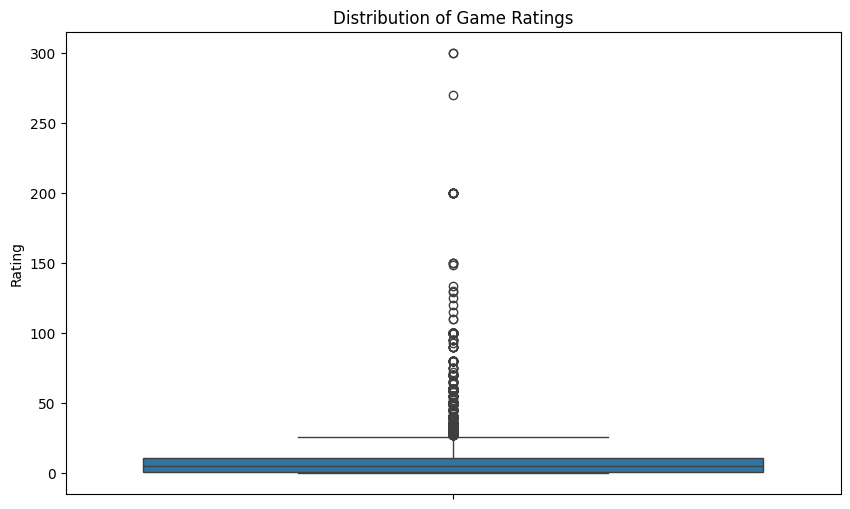

In [14]:
# Boxplot for game ratings
plt.figure(figsize=(10, 6))
sns.boxplot(y=games_df['price_final'])
plt.title('Distribution of Game Ratings')
plt.ylabel('Rating')
plt.show()

> The price range is between 0-12 USD, There are many outliers which means there are many games with prices around 15 to 300 USD! 
#### How do the prices (final_price) of games vary across different levels of ratings?
> Based on experience we change the range for Final_Price to 0 - 50 USD

In [15]:
# Filter out outliers in the final prices
filtered_games_df = games_df[games_df['price_final'] <= 50]

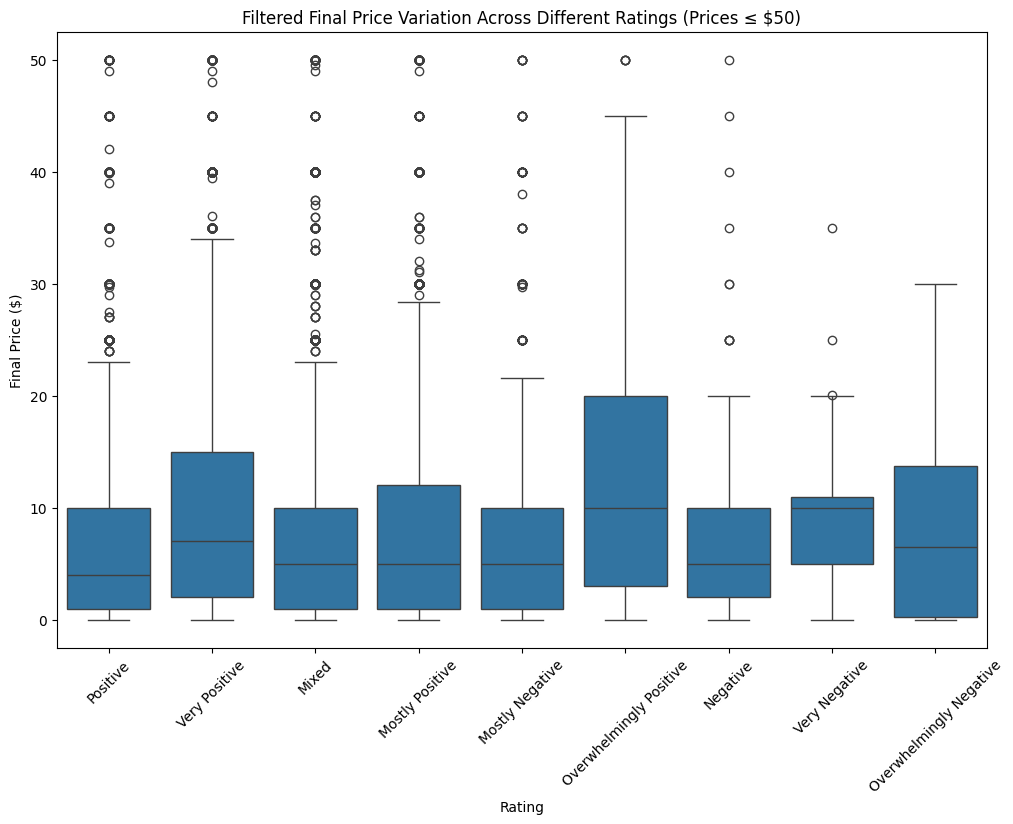

In [16]:
# Boxplot for final prices within the $0-$50 range based on ratings
plt.figure(figsize=(12, 8))
sns.boxplot(x='rating', y='price_final', data=filtered_games_df, order=filtered_games_df['rating'].value_counts().index)
plt.title('Filtered Final Price Variation Across Different Ratings (Prices ≤ $50)')
plt.xlabel('Rating')
plt.ylabel('Final Price ($)')
plt.xticks(rotation=45)
plt.show()

> Overwhelmingly Positive, Very Positive and Very Negative have the highest mean price between different Ratings! The other Ratings have almost the same range of price!  
The number of outliers varies between different rating groups, Mixed and Positive Ratings have the highest amount of outliers (prices over the normal range 0-12 USD)! 
#### Are there any patterns or trends in the release dates of games? 

In [17]:
# Convert 'date_release' to datetime format
games_df['date_release'] = pd.to_datetime(games_df['date_release'], errors='coerce')

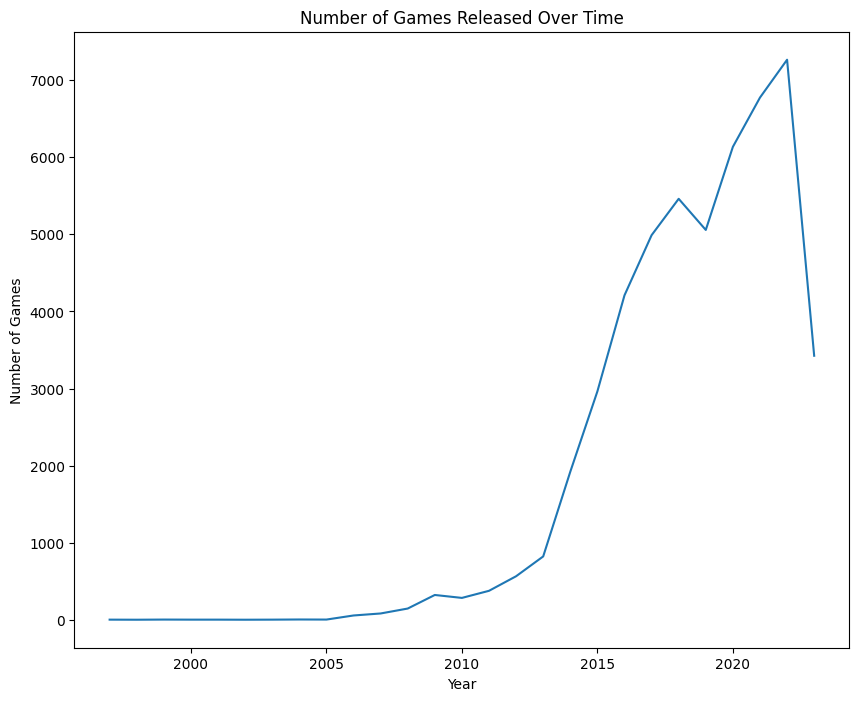

In [18]:
# Plotting the number of games released over time
plt.figure(figsize=(10, 8))
games_df['date_release'].dt.year.value_counts().sort_index().plot(kind='line')
plt.title('Number of Games Released Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Games')
plt.show()

> There is a clear upward or positive trend in number of games released from 2000 to 2022, then it decreases! (The decrease in the plot maybe is due to not having enough data points from 2023 and later, the dataset was collected during 2023)!
#### What proportion of games are available on Windows, Mac, and Linux platforms?

In [19]:
platforms = ['win', 'mac', 'linux']
platform_counts = {platform: games_df[platform].sum() for platform in platforms}

# Total number of games
total_games = len(games_df)

# Proportion of games available on each platform
platform_proportions = {platform: count / total_games * 100 for platform, count in platform_counts.items()}

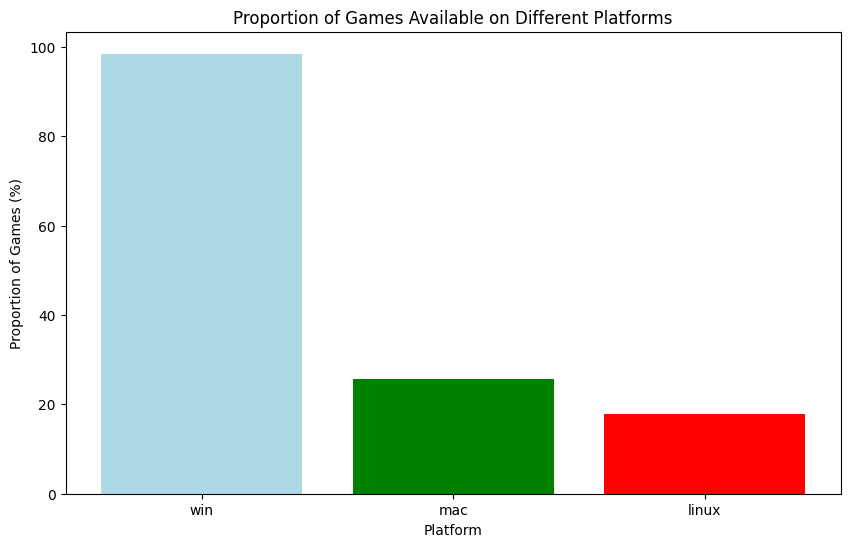

In [20]:
# Plotting the proportions
plt.figure(figsize=(10, 6))
plt.bar(platform_proportions.keys(), platform_proportions.values(), color=['lightblue', 'green', 'red'])
plt.title('Proportion of Games Available on Different Platforms')
plt.xlabel('Platform')
plt.ylabel('Proportion of Games (%)')
plt.show()

> As expected the proportion of games for 'Windows' is much more than the proportion of games for 'Mac' and 'Linux'!
#### How does the positive_ratio correlate with the number of user_reviews?

In [21]:
# Calculate the correlation between 'positive_ratio' and 'user_reviews'
correlation_value = games_df['positive_ratio'].corr(games_df['user_reviews'])

# Print the correlation value
print(f"Correlation between Positive Ratio and Number of User Reviews: {correlation_value:.2f}")

Correlation between Positive Ratio and Number of User Reviews: 0.02


> There is very low positive correlation between 'Positive_Ratio' and 'User Reviews', Correlation here is 0.02!
#### What are the discount patterns and how do they relate to the game's rating?

In [22]:
# Categorize the 'discount' feature into bins
discount_bins = [0, 5, 10, 20, 30, 50, 100]
discount_labels = ['0', '<5', '5-10', '10-20', '20-30', '>= 30']
games_df['discount_category'] = pd.cut(games_df['discount'], bins=discount_bins, labels=discount_labels, include_lowest=True)

In [23]:
# Group by 'rating' and 'discount_category' to analyze patterns
discount_rating_group = games_df.groupby(['rating', 'discount_category'], observed=False).size().unstack().fillna(0)
print(discount_rating_group)

discount_category            0  <5  5-10  10-20  20-30  >= 30
rating                                                       
Mixed                    11076  21    54     63    249    694
Mostly Negative           1723   0    11      3     31     81
Mostly Positive           7791  28    58     82    242    537
Negative                   275   0     3      1      8     16
Overwhelmingly Negative     13   0     0      0      1      0
Overwhelmingly Positive   1033   0    12     14     13     38
Positive                 11840  86   180    172    430    794
Very Negative               58   0     0      0      2      0
Very Positive            12094  44   108    104    296    493


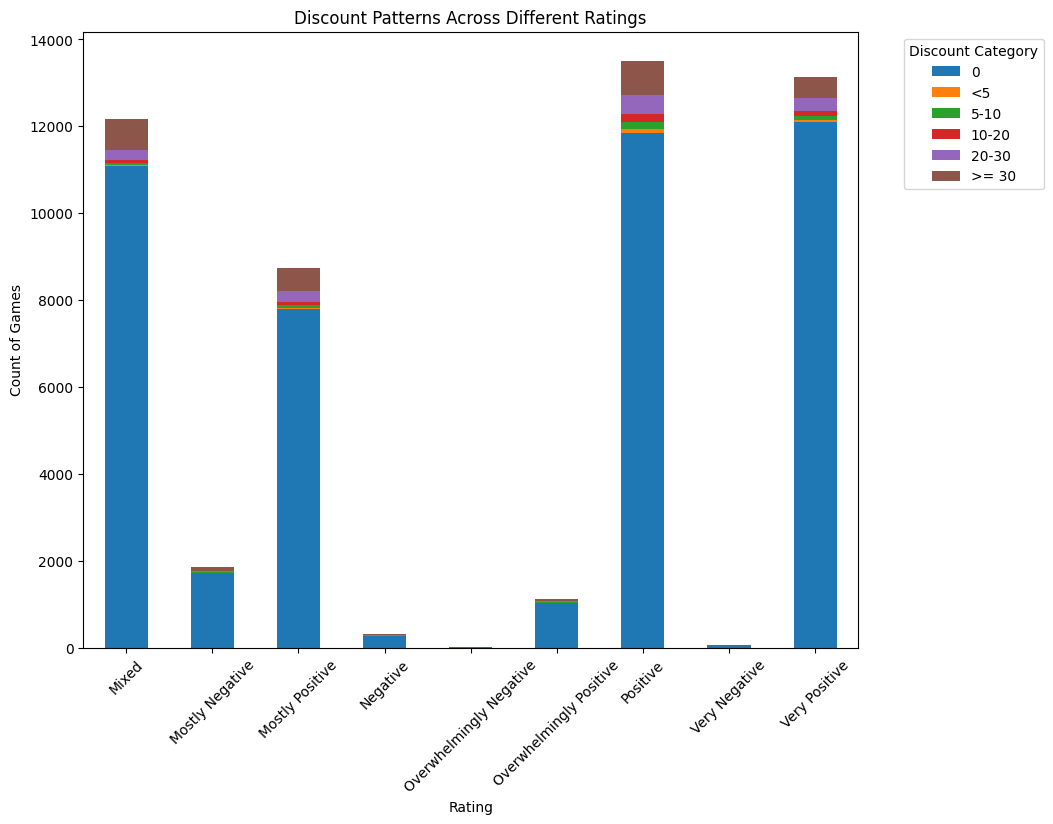

In [24]:
# Bar plot for discount patterns across different ratings
discount_rating_group.plot(kind='bar', stacked=True, figsize=(10, 8))
plt.title('Discount Patterns Across Different Ratings')
plt.xlabel('Rating')
plt.ylabel('Count of Games')
plt.legend(title='Discount Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.show()

> The Zero Discount group is dominent in each game category, the biggest discount group in each category is more than 30% off! 
#### How many games are compatible with Steam Deck, and what are their ratings and prices?
Understanding this feature can help you analyze how compatibility with the Steam Deck impacts game sales, prices, and user reviews.

In [25]:
# Group by 'steam_deck' and calculate counts and mean prices
steam_deck_summary = games_df.groupby('steam_deck').agg({
    'app_id': 'count',  # Count of games
    'price_original': 'mean',  # Mean of original prices
    'price_final': 'mean'  # Mean of final prices
}).reset_index()

# Rename columns for better understanding
steam_deck_summary.rename(columns={'app_id': 'count_games'}, inplace=True)

# Display the summary
print(steam_deck_summary)

   steam_deck  count_games  price_original  price_final
0       False            2       17.495000    17.495000
1        True        50870        8.726443     8.619976


> Almost all the games are compatible by the Steam Deck
### EDA on Users
#### What is the distribution of the number of purchased products among users?

In [26]:
products_summary = users_df['products'].describe()
print(products_summary)

count    1.430606e+07
mean     1.163734e+02
std      2.438515e+02
min      0.000000e+00
25%      2.300000e+01
50%      5.500000e+01
75%      1.270000e+02
max      3.221400e+04
Name: products, dtype: float64


#### How does the number of reviews correlate with the number of purchased products?

In [27]:
# Calculate the correlation between 'products' and 'reviews'
correlation_value = users_df['products'].corr(users_df['reviews'])

# Print the correlation value
print(f"Correlation between the Number of Purchased Products and the Number of Reviews: {correlation_value:.2f}")

Correlation between the Number of Purchased Products and the Number of Reviews: 0.24


> Small positive correlation between the number of purchased products and the number of reviews!
#### What proportion of users have published at least one review versus those who haven't?

In [28]:
# Group by the 'reviews' feature and calculate the counts
reviews_count = users_df['reviews'].value_counts()

# Calculate the proportions
reviews_proportion = reviews_count / users_df.shape[0] * 100

### EDA on Recommendation
#### What is the distribution of helpful and funny counts in the reviews?

In [29]:
# Count occurrences for 'helpful'
helpful_counts = recommendations_df['helpful'].value_counts().sort_index()
# Top 10 values for 'helpful'
top_10_helpful = helpful_counts.head(10)

# Count occurrences for 'funny'
funny_counts = recommendations_df['funny'].value_counts().sort_index()
# Top 10 values for 'funny'
top_10_funny = funny_counts.head(10)

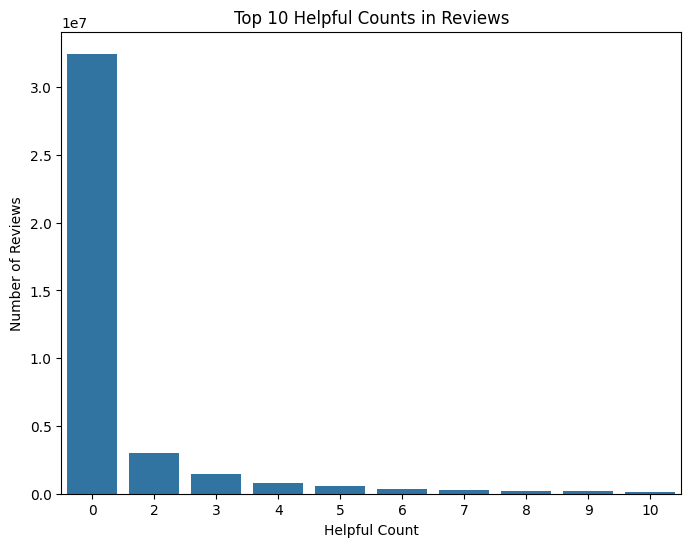

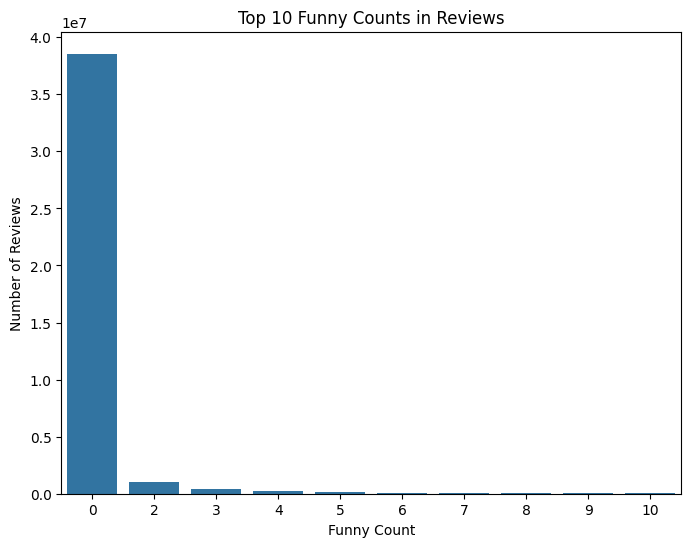

In [30]:
# Top 10 bar plot for 'helpful' counts
plt.figure(figsize=(8, 6))
sns.barplot(x=top_10_helpful.index, y=top_10_helpful.values)
plt.title('Top 10 Helpful Counts in Reviews')
plt.xlabel('Helpful Count')
plt.ylabel('Number of Reviews')
plt.show()

# Top 10 bar plot for 'funny' counts
plt.figure(figsize=(8, 6))
sns.barplot(x=top_10_funny.index, y=top_10_funny.values)
plt.title('Top 10 Funny Counts in Reviews')
plt.xlabel('Funny Count')
plt.ylabel('Number of Reviews')
plt.show()

> 0 category is dominant in both Funny Count and Helpful Count features!
#### Are there any patterns or trends in the review dates over time?

In [31]:
# Convert 'date' to datetime format
recommendations_df['date'] = pd.to_datetime(recommendations_df['date'], errors='coerce')

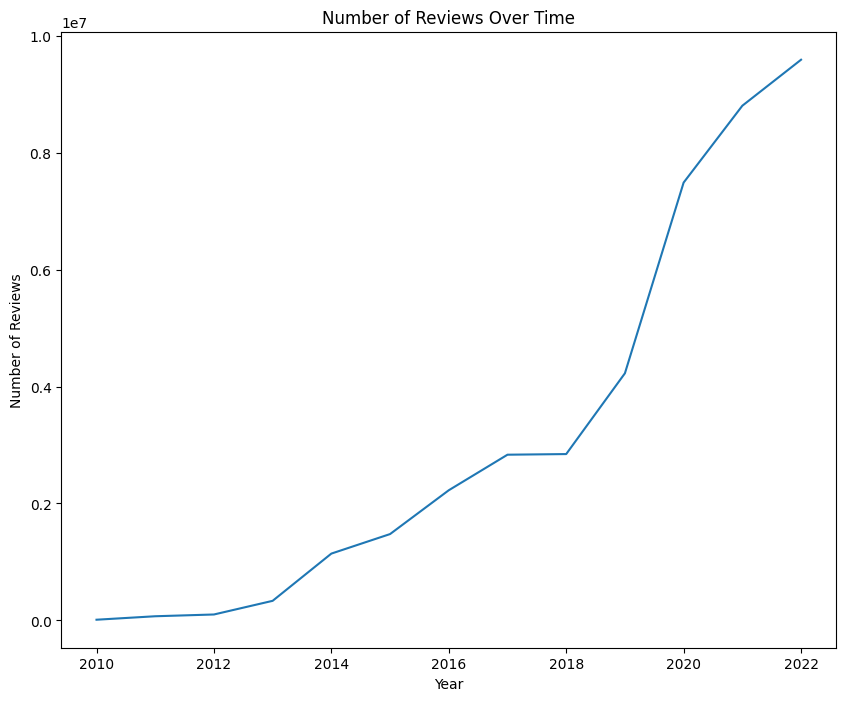

In [32]:
# Plotting the number of reviews over time
plt.figure(figsize=(10, 8))
recommendations_df['date'].dt.year.value_counts().sort_index().plot(kind='line')
plt.title('Number of Reviews Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.show()

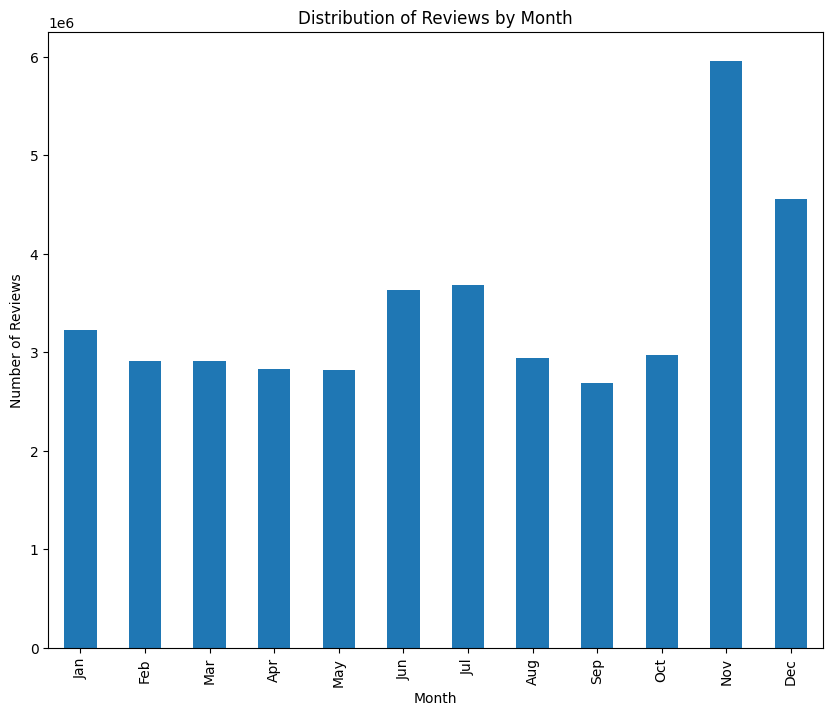

In [33]:
#  Plot monthly trends
plt.figure(figsize=(10, 8))
recommendations_df['date'].dt.month.value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Reviews by Month')
plt.xlabel('Month')
plt.ylabel('Number of Reviews')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()


> There is a very positive trend in the number of reviews from 2010 to 2020! The most number of reviews are under November!  

#### What proportion of reviews are marked as recommended versus not recommended?

In [34]:
# Group by the 'is_recommended' feature and calculate the counts
recommendation_counts = recommendations_df['is_recommended'].value_counts()

# Calculate the proportions
recommendation_proportions = recommendation_counts / recommendations_df.shape[0] * 100

# Display the proportions
print(recommendation_proportions)

is_recommended
True     85.784412
False    14.215588
Name: count, dtype: float64


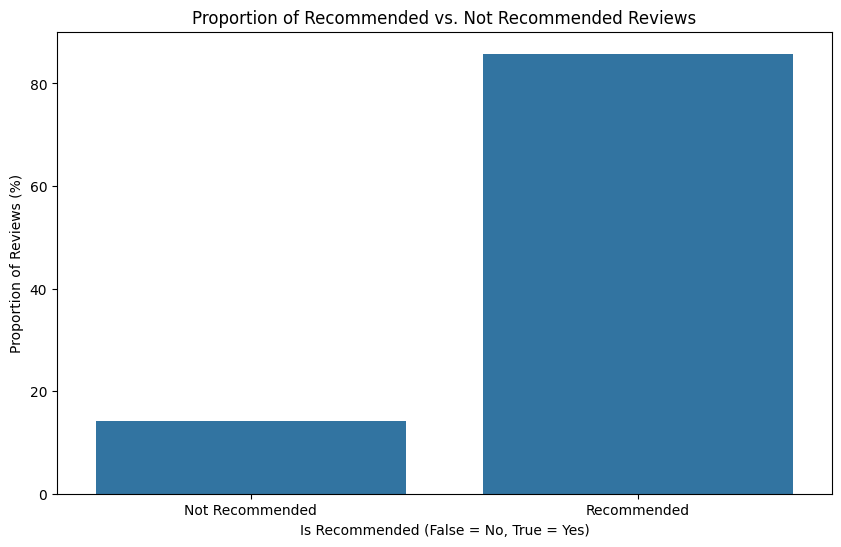

In [35]:
# Bar plot for the proportion of recommended vs. not recommended reviews
plt.figure(figsize=(10, 6))
sns.barplot(x=recommendation_proportions.index, y=recommendation_proportions.values)
plt.title('Proportion of Recommended vs. Not Recommended Reviews')
plt.xlabel('Is Recommended (False = No, True = Yes)')
plt.ylabel('Proportion of Reviews (%)')
plt.xticks([0, 1], ['Not Recommended', 'Recommended'])
plt.show()

## Building the Game Recommendation System With Collaborative Filtering Approach
**Collaborative filtering** is a recommendation approach that predicts a user’s preferences based on past interactions and the behavior of similar users. Imagine you and your friends are sharing your favorite movies. You each have different tastes, but there are some overlaps.

**How it works:**
1. **User-Based Collaborative Filtering**: It's like finding a friend with similar movie tastes. If your friend loves action movies and so do you, chances are you'll like the movies they recommend. The algorithm identifies users with similar preferences and suggests items they enjoyed.
2. **Item-Based Collaborative Filtering**: It's like finding similar movies. If you loved one action movie, the algorithm suggests other action movies that people who liked the first one also enjoyed. It looks at the similarities between items and recommends based on that.

### Data Preprocessing

In [36]:
# Merge recommendations with games on app_id
merged_df = recommendations_df.merge(filtered_games_df, on='app_id', how='inner')

In [37]:
# Merge the result with users on user_id
final_df = merged_df.merge(users_df, on='user_id', how='inner')

In [38]:
final_df.head(2)

,app_id,helpful,funny,date,is_recommended,hours,user_id,review_id,title,date_release,...,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck,products,reviews
0,975370,0,0,2022-12-12,True,36.3,51580,0,Dwarf Fortress,2022-12-06,...,False,Overwhelmingly Positive,95,19665,30.0,0.0,0.0,True,28,5
1,304390,4,0,2017-02-17,False,11.5,2586,1,FOR HONOR™,2017-02-13,...,False,Mixed,69,82277,15.0,0.0,0.0,True,269,1


In [39]:
final_df.isnull().sum()

app_id            0
helpful           0
funny             0
date              0
is_recommended    0
hours             0
user_id           0
review_id         0
title             0
date_release      0
win               0
mac               0
linux             0
rating            0
positive_ratio    0
user_reviews      0
price_final       0
price_original    0
discount          0
steam_deck        0
products          0
reviews           0
dtype: int64

### EDA on the whole dataset
#### Which users and games have the most interactions?

In [40]:
# Count the number of reviews per game
game_interactions = final_df.groupby('app_id').size().reset_index(name='interaction_count')
# Sort by interaction count
top_games = game_interactions.sort_values(by='interaction_count', ascending=False).head(10)

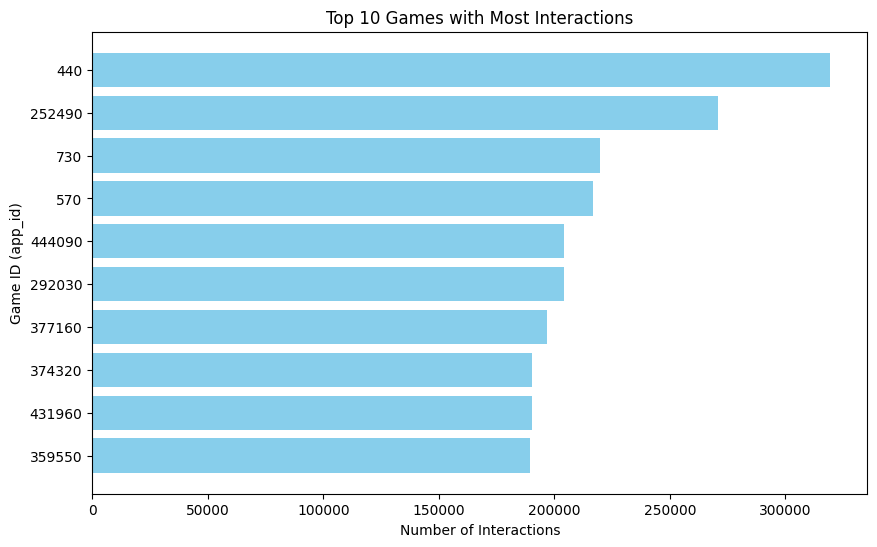

In [41]:
# Visualize top games by interactions
plt.figure(figsize=(10, 6))
plt.barh(top_games['app_id'].astype(str), top_games['interaction_count'], color='skyblue')
plt.xlabel('Number of Interactions')
plt.ylabel('Game ID (app_id)')
plt.title('Top 10 Games with Most Interactions')
plt.gca().invert_yaxis()
plt.show()

In [42]:
# Count the number of reviews per user
user_interactions = final_df.groupby('user_id').size().reset_index(name='review_count')

# Sort by review count
top_users = user_interactions.sort_values(by='review_count', ascending=False).head(10)

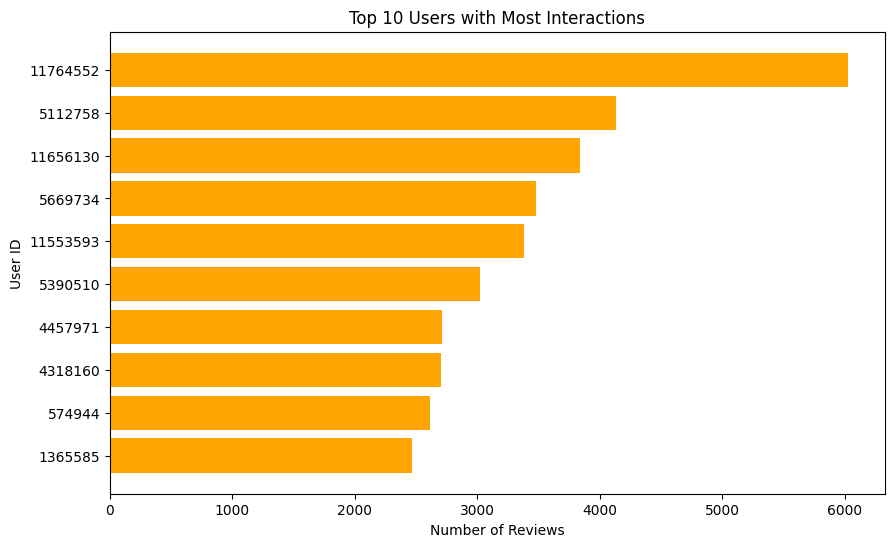

In [43]:
# Visualize top users by interactions
plt.figure(figsize=(10, 6))
plt.barh(top_users['user_id'].astype(str), top_users['review_count'], color='orange')
plt.xlabel('Number of Reviews')
plt.ylabel('User ID')
plt.title('Top 10 Users with Most Interactions')
plt.gca().invert_yaxis()
plt.show()

#### What is the distribution of hours played and its relationship with is_recommended?

In [44]:
# Top 10 most played games
most_played_games = final_df.groupby('app_id')['hours'].sum().reset_index()
most_played_games = most_played_games.sort_values(by='hours', ascending=False).head(10)

In [45]:
print(most_played_games.head(2))

    app_id        hours
18     440  101809977.6
24     730   94260307.3


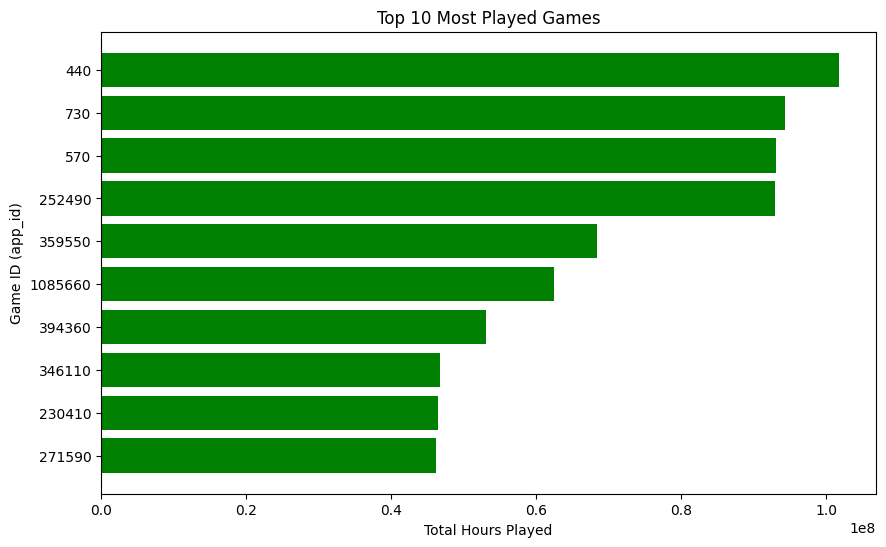

In [46]:
# Visualization for top 10 most played games
plt.figure(figsize=(10, 6))
plt.barh(most_played_games['app_id'].astype(str), most_played_games['hours'], color='green')
plt.xlabel('Total Hours Played')
plt.ylabel('Game ID (app_id)')
plt.title('Top 10 Most Played Games')
plt.gca().invert_yaxis()
plt.show()

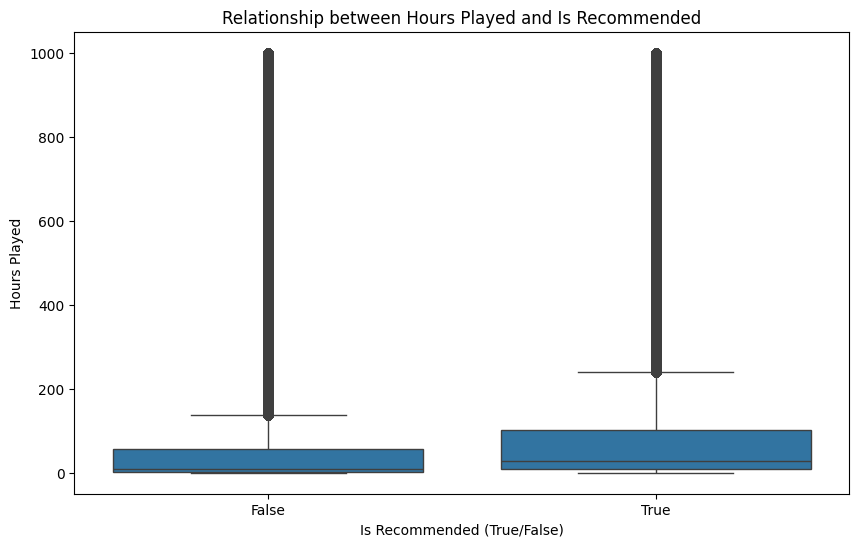

In [47]:
# Relationship between hours played and is_recommended
plt.figure(figsize=(10, 6))
sns.boxplot(data=final_df, x='is_recommended', y='hours')
plt.xlabel('Is Recommended (True/False)')
plt.ylabel('Hours Played')
plt.title('Relationship between Hours Played and Is Recommended')
plt.show()

> The hours range is approximately between 1 - 100 hours! There are many outliers in 'hours' played, let's leave it for now!

#### Does rating correlate with is_recommended?

In [48]:
# Group by 'rating' and calculate the proportion of recommendations
rating_recommendation = final_df.groupby('rating')['is_recommended'].mean().reset_index()

In [49]:
# Rename columns for clarity
rating_recommendation.columns = ['rating', 'recommendation_proportion']

# Sort the ratings for better visualization
rating_recommendation = rating_recommendation.sort_values(by='recommendation_proportion', ascending=False)

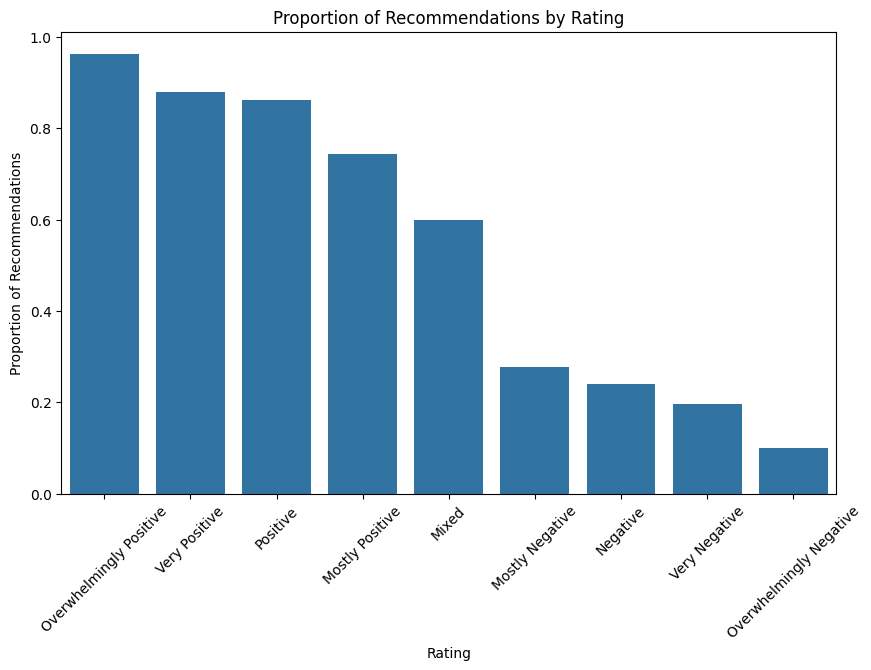

In [50]:
plt.figure(figsize=(10, 6))
sns.barplot(data=rating_recommendation, x='rating', y='recommendation_proportion')
plt.xlabel('Rating')
plt.ylabel('Proportion of Recommendations')
plt.title('Proportion of Recommendations by Rating')
plt.xticks(rotation=45)
plt.show()

> As the rating decreases from Overwhelmingly Positive to Overwhelmingly Negative the proportion of the recommendations decrease as well! There is a positive correlation with a game being overwhelmingly positive and being recommended!  

#### What is the relationship between price_final and user engagement (is_recommended)?

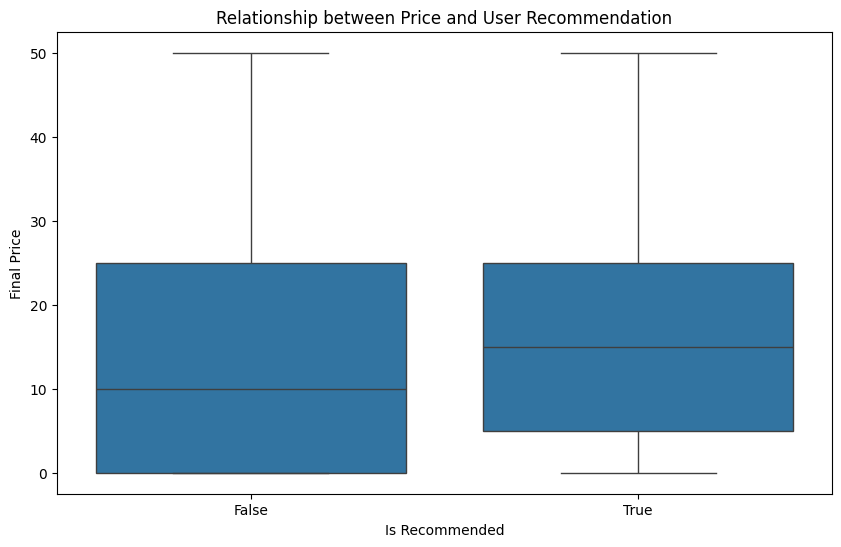

In [51]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_recommended', y='price_final', data=final_df)
plt.title('Relationship between Price and User Recommendation')
plt.xlabel('Is Recommended')
plt.ylabel('Final Price')
plt.show()

> The mean price between recommended games is slightly higher than the not-recommended games!  

### User-Based Collaborative Filtering
This approach focuses on finding similarities between users' preferences and recommending games based on what similar users have liked.

In [52]:
# Filter the relevant columns
filtered_df = final_df[['user_id', 'app_id', 'rating', 'hours']]
# is_recommended could also be included, let's start first with the 'rating'!

# Display the filtered DataFrame
print(filtered_df.head())

   user_id   app_id                   rating  hours
0    51580   975370  Overwhelmingly Positive   36.3
1     2586   304390                    Mixed   11.5
2   253880  1085660            Very Positive  336.5
3   259432   703080            Very Positive   27.4
4    23869   526870  Overwhelmingly Positive    7.9


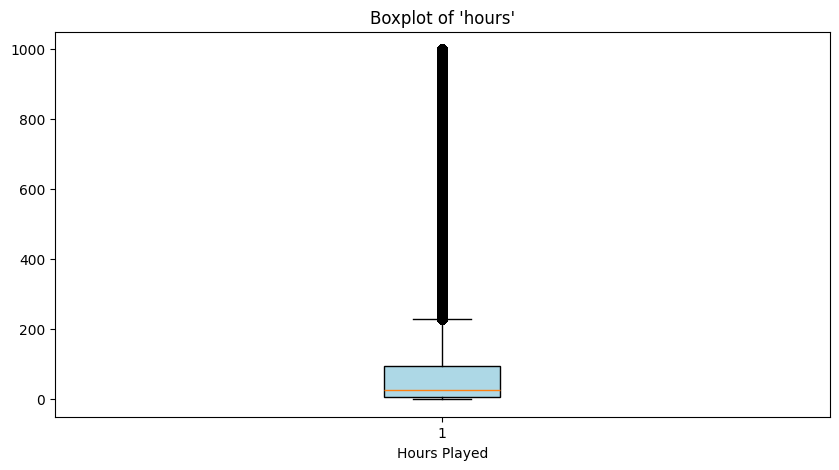

In [53]:
# 1. Visualize outliers with a boxplot
plt.figure(figsize=(10, 5))
plt.boxplot(filtered_df['hours'], patch_artist=True, boxprops=dict(facecolor="lightblue"))
plt.title("Boxplot of 'hours'")
plt.xlabel("Hours Played")
plt.show()

In [72]:
# 1. Filter out extreme values beyond 300 hours
filtered_df_cut = filtered_df[filtered_df['hours'] <= 300]

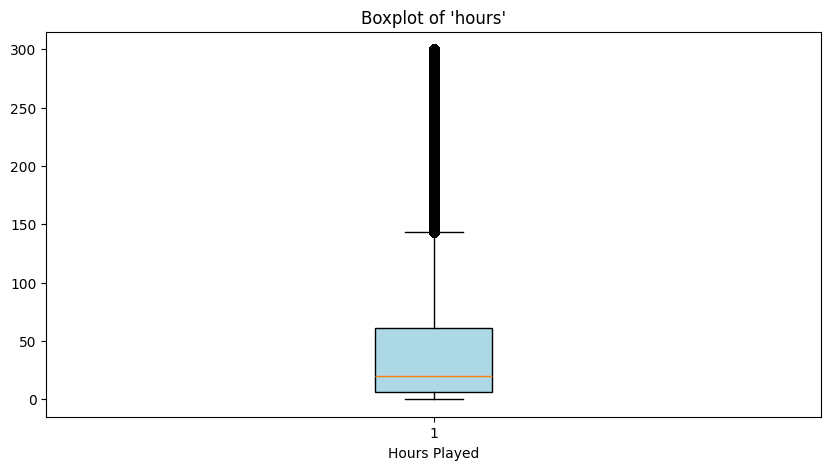

In [73]:
plt.figure(figsize=(10, 5))
plt.boxplot(filtered_df_cut['hours'], patch_artist=True, boxprops=dict(facecolor="lightblue"))
plt.title("Boxplot of 'hours'")
plt.xlabel("Hours Played")
plt.show()

In [84]:
filtered_df_cut.head(2)

,user_id,app_id,rating,hours,rating_numeric
0,51580,975370,Overwhelmingly Positive,36.3,5.0
1,2586,304390,Mixed,11.5,2.0


In [85]:
filtered_df_cut.shape

(34897072, 5)

> The size of the dataset is too large, we are taking **startified sampling** of the dataset!

In [90]:
filtered_df_cut = filtered_df_cut.dropna(subset=['rating_numeric'])

In [103]:
# Define the sample size (e.g., 10% of the dataset or any specific number of rows)
sample_size = 0.03  # # 3% of the dataset (~1M rows)

# Stratified sampling based on 'rating' or 'rating_numeric'
sampled_df, _ = train_test_split(
    filtered_df_cut,
    stratify=filtered_df_cut['rating_numeric'],  # Ensure the representation of 'rating'
    test_size=1 - sample_size,
    random_state=42
)

In [104]:
sampled_df.shape

(926075, 5)